## imports

In [10]:
import os

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme('notebook')
import numpy as np 

import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# Hyperparams
EPOCHS = 10
BATCH_SIZE = 64

In [3]:
# download data
# !wget https://download.pytorch.org/tutorial/data.zip 
# !unzip data.zip

## Load data

In [4]:
class NamesDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir='data/names', min_count=None):
        self.root_dir = root_dir
        self.files_list = os.listdir(root_dir)
        self.data = []
        self.labels = []
        self.idx_to_class = {i: file.split('.')[0] for i, file in enumerate(self.files_list)}
        for i, file in enumerate(self.files_list):
            with open(f'{root_dir}/{file}', 'r', encoding='utf-8') as f:
                for line in f:
                    self.data.append(line.strip())
                    self.labels.append(i)
        self.labels = self.labels

        if min_count:
            self.data, self.labels = self._filter(min_count)
    
    def _filter(self, min_count):
        labels, counts = np.unique(self.labels, return_counts=True)

        filtered_classes = labels[counts >= min_count]

        # only keep min_count samples from each class
        filtered_data = []
        filtered_labels = []
        for c in filtered_classes:
            filtered_data.extend([d for d, l in zip(self.data, self.labels) if l == c][:min_count])
            filtered_labels.extend([c] * min_count)

        print(f'Only kept {min_count} samples from each class.')
        print(f'Remaining classes: {[self.idx_to_class[label] for label in np.unique(filtered_labels)]}')
        
        return filtered_data, filtered_labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [5]:
# Load dataset
dataset = NamesDataset(min_count=700)
print(f"Dataset Loaded with {len(dataset):,} samples")

# Train valid split
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
print(f"Train: {len(train_dataset):,} samples\nValid: {len(valid_dataset):,} samples")

Only kept 700 samples from each class.
Remaining classes: ['Arabic', 'English', 'German', 'Italian', 'Japanese', 'Russian']
Dataset Loaded with 4,200 samples
Train: 3,360 samples
Valid: 840 samples


In [40]:
num_classes = len(set(dataset.labels))
print(f'Number of classes: {num_classes}')

Number of classes: 6


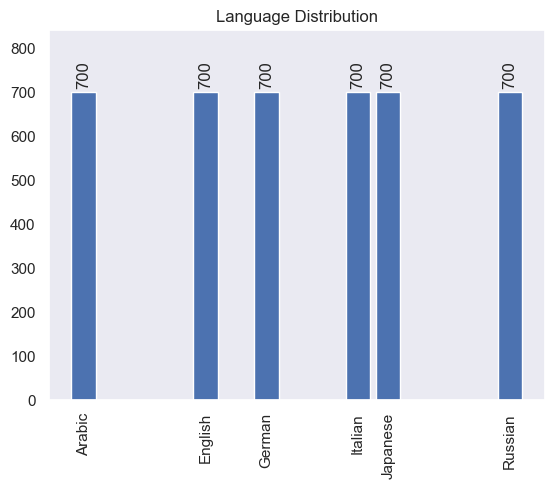

In [6]:
labels, counts = np.unique(dataset.labels, return_counts=True)
max_y = max(counts)
# Bar plot
plt.title('Language Distribution')
plt.bar(labels, counts)
plt.xticks(labels, [dataset.idx_to_class[i] for i in labels], rotation=90)

# Add counts on top of the bars
for i, count in zip(labels, counts):
    plt.text(i, count+0.01*max_y, str(count), ha='center', va='bottom', rotation=90)

# add some padding to the top
plt.ylim(0, int(max_y*1.2))

plt.grid(False)
plt.show()


In [7]:
# Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# display a batch
data, labels = next(iter(train_loader))
for i in range(min(10, len(data))):
    print(f"{data[i]}: {dataset.idx_to_class[labels[i].item()]}")

Adjemov: Russian
Asom: English
Najjar: Arabic
Allsop: English
Mustafa: Arabic
Siskin: German
Hishikawa: Japanese
Bentley: English
Fabbri: Italian
Boerio: Italian


### Vocab

In [38]:
def create_vocab(dataset):
    vocab = set()
    max_name_length = 0
    for name, label in dataset:
        max_name_length = max(max_name_length, len(name))
        for ch in name:
            vocab.add(ch)
    vocab = sorted(list(vocab))
    return vocab, max_name_length

vocab, max_name_length = create_vocab(dataset)

# print the vocab
print("Vocab:", end="")
for ch in vocab:
    print(ch, end="")
print()
print("Max name length:", max_name_length)

Vocab: '-ABCDEFGHIJKLMNOPQRSTUVWZabcdefghijklmnopqrstuvwxyzßàäèéìòóöùü
Max name length: 18


### Conversion functions

In [39]:
def char_to_id(ch, vocab=vocab):
    return vocab.index(ch)

def id_to_char(id, vocab=vocab):
    return vocab[id]

In [134]:
# convert dataset to tensor
def name_to_tensor(name, max_name_length=max_name_length, vocab=vocab):
    tensor = torch.zeros(max_name_length, dtype=torch.long)
    for i, ch in enumerate(name):
        tensor[i] = char_to_id(ch)
    return tensor

def tensor_to_name(tensor, vocab=vocab):
    name = ""
    for i in tensor:
        name += id_to_char(i)
    return name

In [135]:
num_classes

6

In [145]:
nn.Embedding(len(vocab), 3)(torch.tensor([[0, 1, 2, 3, 4],[5,6,7,8,9]])).shape

torch.Size([2, 5, 3])

In [252]:
# create a model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self, num_classes=num_classes) -> None:
        super().__init__()
        self.emb = nn.Embedding(len(vocab), 32)
        self.fc1 = nn.Linear(max_name_length*32, 128)
        self.fc2 = nn.Linear(128, 15)

    def forward(self, x):
        x = self.emb(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [296]:
a = torch.zeros(len(vocab), 32)
576/32

18.0

In [253]:
def train(model, train_loader, device, epoch, optimizer, print_every=100):
    loss_function = nn.CrossEntropyLoss()
    model.train()
    total_loss = 0
    for i, (X, y) in enumerate(train_loader):
        X = torch.cat([name_to_tensor(name) for name in X])
        X = X.reshape(-1, max_name_length)
        X, y = X.to(device), y.to(device)
        y = y.long()
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # if i % print_every == 0:
        #     print(f'Epoch {epoch}, Batch {i}/{len(train_loader)}, Loss: {loss.detach().cpu().item()}')
    
    train_accuracy = evaluate(model, train_loader, device)
    return train_accuracy, total_loss / len(train_loader)

def evaluate(model, valid_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in valid_loader:
            X = torch.cat([name_to_tensor(name) for name in X])
            X = X.reshape(-1, max_name_length)
            X, y = X.to(device), y.to(device)
            y = y.long()
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    # print(f'Accuracy: {correct/total:.2f} ({correct}/{total})')
    return correct / total

## Training

In [284]:
model = MLP(num_classes=num_classes).to(device)
train_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

In [285]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 100
print('Training...')
for epoch in range(EPOCHS):
    train_acc, train_loss = train(model, train_loader, device, epoch, optimizer, print_every=100)
    val_acc = evaluate(model, valid_loader, device)

    # save history
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_acc)
    valid_accuracy_history.append(val_acc)

    # print stats
    print(f"epoch: {epoch}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}")


Training...
epoch: 0, train_loss: 1.3397, train_acc: 0.6485, val_acc: 0.6417
epoch: 1, train_loss: 0.8202, train_acc: 0.7530, val_acc: 0.7131
epoch: 2, train_loss: 0.6530, train_acc: 0.7940, val_acc: 0.7512
epoch: 3, train_loss: 0.5639, train_acc: 0.8208, val_acc: 0.7786
epoch: 4, train_loss: 0.4925, train_acc: 0.8423, val_acc: 0.7845
epoch: 5, train_loss: 0.4425, train_acc: 0.8717, val_acc: 0.8107
epoch: 6, train_loss: 0.3982, train_acc: 0.8586, val_acc: 0.8119
epoch: 7, train_loss: 0.3754, train_acc: 0.8949, val_acc: 0.8345
epoch: 8, train_loss: 0.3440, train_acc: 0.8955, val_acc: 0.8310
epoch: 9, train_loss: 0.3132, train_acc: 0.9060, val_acc: 0.8310
epoch: 10, train_loss: 0.2875, train_acc: 0.9170, val_acc: 0.8393
epoch: 11, train_loss: 0.2748, train_acc: 0.9071, val_acc: 0.8381
epoch: 12, train_loss: 0.2565, train_acc: 0.9360, val_acc: 0.8571
epoch: 13, train_loss: 0.2243, train_acc: 0.9396, val_acc: 0.8560
epoch: 14, train_loss: 0.2206, train_acc: 0.9455, val_acc: 0.8595
epoch: 1

In [320]:
print("Train acc:")
print(evaluate(model, train_loader, device))
print("Test acc:")
print(evaluate(model, valid_loader, device))

Train acc:
0.9943452380952381
Test acc:
0.8857142857142857


## Training History

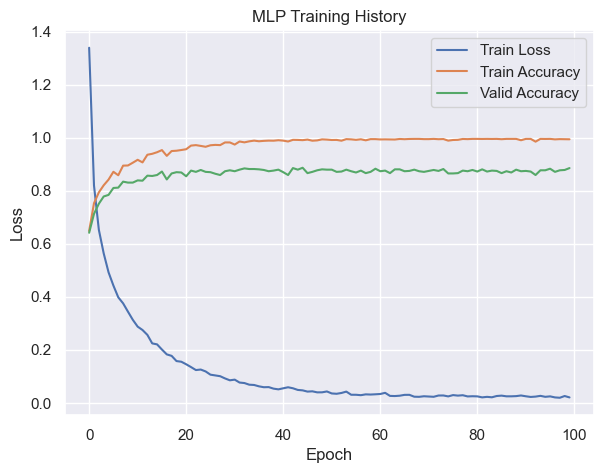

In [288]:
# Plot the history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('MLP Training History')
plt.plot(train_loss_history, label='Train Loss')
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(valid_accuracy_history, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

## Classification reports

In [322]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X, y in valid_loader:
        X = torch.cat([name_to_tensor(name) for name in X])
        X = X.reshape(-1, max_name_length)
        X, y = X.to(device), y.to(device)
        y = y.long()
        y_pred.extend(model(X).argmax(dim=1).cpu().numpy())
        y_true.extend(y.cpu().numpy())

y_true = [dataset.idx_to_class[i] for i in y_true]
y_pred = [dataset.idx_to_class[i] for i in y_pred]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Arabic       0.95      0.97      0.96       148
     English       0.87      0.78      0.82       132
      German       0.86      0.85      0.85       150
     Italian       0.83      0.83      0.83       124
    Japanese       0.93      0.92      0.92       154
     Russian       0.86      0.95      0.90       132

    accuracy                           0.89       840
   macro avg       0.88      0.88      0.88       840
weighted avg       0.89      0.89      0.88       840



In [323]:
i,j = np.unique(np.array(y_pred), return_counts=True)
for i, j in zip(i,j):
    print(f'{i}: {j}')

Arabic: 151
English: 119
German: 148
Italian: 124
Japanese: 151
Russian: 147


## Confusion Matrix

In [324]:
dataset.idx_to_class[1]

'Chinese'

In [325]:
y_true[0], y_pred[0]
xtick_labels = np.unique(y_true)
xtick_labels

array(['Arabic', 'English', 'German', 'Italian', 'Japanese', 'Russian'],
      dtype='<U8')

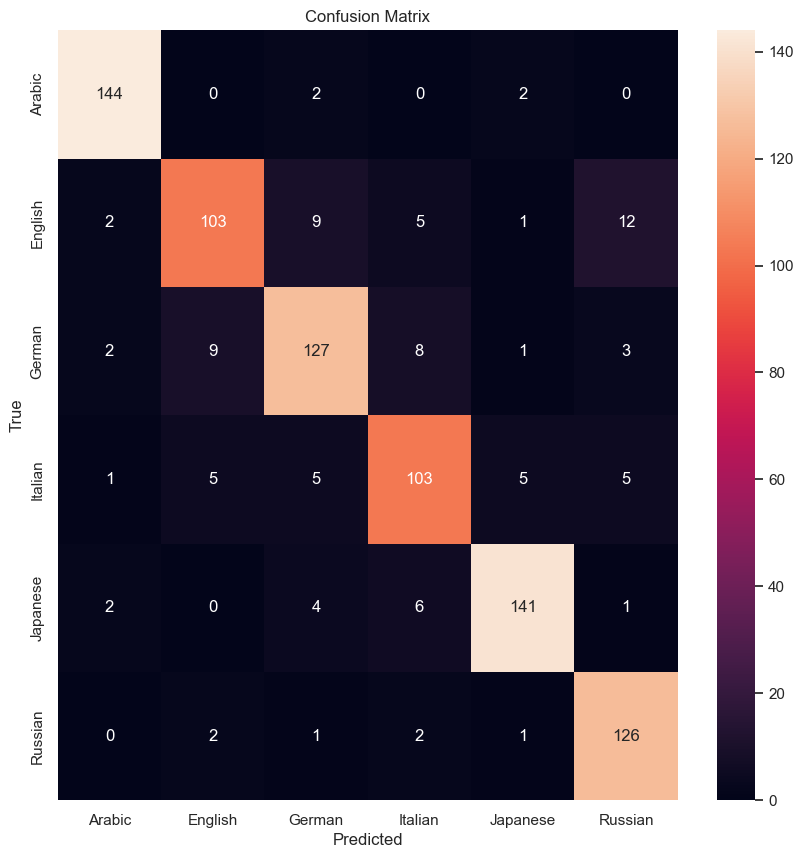

In [326]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
# cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
# write numbers not in scientific notation
sns.heatmap(cm, annot=True, fmt='d', xticklabels=xtick_labels, yticklabels=xtick_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Print a few predictions (Sanity Check)

In [302]:
# Print a few predictions
model.eval()
with torch.no_grad():
    for X, y in valid_loader:
        X = torch.cat([name_to_tensor(name) for name in X])
        X = X.reshape(-1, max_name_length)
        X, y = X.to(device), y.to(device)
        y = y.long()
        y_pred = model(X)
        _, predicted = torch.max(y_pred.data, 1)
        for i in range(min(10, len(X))):
            true_label = dataset.idx_to_class[y[i].item()]
            predicted_label = dataset.idx_to_class[predicted[i].item()]
            is_correct = true_label == predicted_label

            print(f"{tensor_to_name(X[i])} | {true_label} | {predicted_label} {'' if is_correct else '❌'}")

Arena              | Italian | Italian 
Okita              | Japanese | Japanese 
Pesce              | Italian | Italian 
Button             | English | English 
Glöckner           | German | German 
Barlow             | English | English 
Ichisada           | Japanese | Japanese 
Hayakawa           | Japanese | Japanese 
Devaney            | English | English 
Ableukhov          | Russian | Russian 
Ghanem             | Arabic | Arabic 
Adkins             | English | Russian ❌
Segreti            | Italian | Italian 
Essa               | Arabic | Arabic 
Aloia              | Italian | Japanese ❌
Brelsford          | English | English 
Falkenrath         | German | German 
Adenauer           | German | Russian ❌
Ghannam            | Arabic | Arabic 
Aylward            | English | English 
Agaponov           | Russian | Russian 
Ferrara            | Italian | Italian 
Kaibara            | Japanese | Japanese 
Langer             | German | German 
Nagano             | Japanese | Japanese 